In [1]:
import torch
import os



# GPU 할당 변경하기
GPU_NUM = 4  # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')

torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check



Current cuda device  4


In [2]:
import time
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

### S_left.npy, S_right.npy

In [3]:
S_left  = np.load('../../data/S_left.npy')
S_right = np.load('../../data/S_right.npy')


"""logscale [dB]"""
S_left  = librosa.amplitude_to_db(S_left)
S_right = librosa.amplitude_to_db(S_right)

In [4]:

"""normalization"""
LR = torch.empty(1,257,382*2).to('cuda:3')
scaler = StandardScaler()


num = S_left.shape[2]
for idx in range(num):
    L = S_left[:,:,idx]
    R = S_right[:,:,idx]
    LR_data = np.concatenate([L,R], axis=1 )
    scaled_LR = scaler.fit_transform(LR_data)
    scaled_LR = torch.as_tensor( scaled_LR ).reshape(1,257,382*2).to('cuda:3')
    LR = torch.cat([LR, scaled_LR],axis=0)


scaled_L = LR[1:,:,:382].reshape(1000,1,257,382).to('cuda:3')
scaled_R = LR[1:,:,382:].reshape(1000,1,257,382).to('cuda:3')

scaled_L.shape, scaled_R.shape

(torch.Size([1000, 1, 257, 382]), torch.Size([1000, 1, 257, 382]))

In [ ]:
scaled_L = scaled_L.to(device)
scaled_R = scaled_R.to(device)

### UNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



def conv_trans_block( in_dim, out_dim, act_fn ):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        # (H-1)*2 -2*1 + 1*(3-1) +1 +1 = 2*H
        nn.BatchNorm2d(out_dim),
        act_fn)
    return model


# (H,W) -> (H/2, W/2)
def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool


def conv_block( in_dim, out_dim, act_fn ):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
        nn.Conv2d(out_dim, out_dim, kernel_size=3,  padding=1),
        nn.BatchNorm2d(out_dim),
        )
    return model


def conv_input( in_dim, out_dim, act_fn ):
    model = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=(3,2), padding=1), # H, W+1
            nn.BatchNorm2d(out_dim),
            act_fn,
            nn.Conv2d(out_dim, out_dim, kernel_size=(2,2),  padding=(0,1)), # H-1, W+1
            nn.BatchNorm2d(out_dim),
            )
    return model


def conv_output( in_dim, out_dim, act_fn ):
    model = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=(3,4), padding=(1,1)), # H, W-1
            nn.BatchNorm2d(out_dim),
            act_fn,
            nn.Conv2d(out_dim, out_dim, kernel_size=(2,4),  padding=(1,1)), # H+1, W-1
            nn.BatchNorm2d(out_dim),
            )
    return model


def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.1)
        

In [ ]:
class UnetGenerator(nn.Module):
    def __init__(self, in_dim, out_dim, num_filter):
        super(UnetGenerator, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)
        
        
        self.down_1 = conv_input(self.in_dim, self.num_filter*1, act_fn) #(257,382) -> (1,256,384)
        self.pool_1 = maxpool() #(1,256,384) -> (1,128,192)
        self.down_2 = conv_block(self.num_filter*1, self.num_filter*2, act_fn) 
        self.pool_2 = maxpool() #(1,128,192) -> (2,64,96)
        self.down_3 = conv_block(self.num_filter*2, self.num_filter*4, act_fn)
        self.pool_3 = maxpool() #(2,64,96) -> (4,32,48)
        self.down_4 = conv_block(self.num_filter*4, self.num_filter*8, act_fn)
        self.pool_4 = maxpool() #(4,32,48) -> (8,16,24)
        self.bridge = conv_block(self.num_filter*8, self.num_filter*16, act_fn) #(8,32,48) -> (16,16,24)
        
    
        self.trans_1 = conv_trans_block(self.num_filter*16, self.num_filter*8, act_fn)
        self.up_1 = conv_block(self.num_filter*16, self.num_filter*8, act_fn) #(16,16,24) -> (8,32,48)    
        self.trans_2 = conv_trans_block(self.num_filter*8, self.num_filter*4, act_fn)
        self.up_2 = conv_block(self.num_filter*8, self.num_filter*4, act_fn) #(8,32,48)  -> (4,64,96)
        self.trans_3 = conv_trans_block(self.num_filter*4, self.num_filter*2, act_fn)
        self.up_3 = conv_block(self.num_filter*4, self.num_filter*2, act_fn) #(4,64,96)  -> (2,128,192)
        self.trans_4 = conv_trans_block(self.num_filter*2, self.num_filter*1, act_fn)
        self.up_4 = conv_output(self.num_filter*2, self.num_filter*1, act_fn) #(2,128,192) -> (1,257,382)
        
        self.out = nn.Sequential(
                nn.Conv2d(self.num_filter, self.out_dim, kernel_size=3, padding=1),
                nn.Tanh()
        )
        
        
    def forward(self, input):

        #(N,1,257,382)
        down_1 = self.down_1(input)  #(N,1*C,256,384)
        pool_1 = self.pool_1(down_1) #(N,1*C,128,192)        
        down_2 = self.down_2(pool_1) 
        pool_2 = self.pool_2(down_2) #(N,2*C,64,96)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3) #(N,4*C,32,48)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4) #(N,8*C,16,24)

        bridge = self.bridge(pool_4) #(N,16*C,16,24)

        trans_1  = self.trans_1(bridge) #(N,8*C,32,48)
        concat_1 = torch.cat([trans_1, down_4], dim=1) #(N,16*C,32,48)
        up_1     = self.up_1(concat_1) #(N,8*C,32,48)
        trans_2  = self.trans_2(up_1)  #(N,4*C,64,96)
        concat_2 = torch.cat([trans_2, down_3], dim=1) #(N,8*C,64,96)
        up_2     = self.up_2(concat_2) #(N,4*C,64,96)
        trans_3  = self.trans_3(up_2)  #(N,2*C,128,192)
        concat_3 = torch.cat([trans_3, down_2], dim=1)  #(N,4*C,128,192)
        up_3     = self.up_3(concat_3) #(N,2*C,128,192)
        trans_4  = self.trans_4(up_3)  #(N,C,256,384)
        concat_4 = torch.cat([trans_4, down_1], dim=1)  #(N,2*C,256,384)
        up_4     = self.up_4(concat_4) #(N,C,257,382)

        out = self.out(up_4)

        return out


In [ ]:
from collections import OrderedDict

in_dim=1
out_dim=1
num_filter=64
epoch=50
lr=0.00001

checkpoint = torch.load('../Unet2')
state_dict =checkpoint['model_state_dict']


new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove 'module.' of dataparallel
    new_state_dict[name]=v

    
    
model = UnetGenerator(in_dim=in_dim, out_dim=out_dim,
                      num_filter=num_filter)
model.load_state_dict(new_state_dict)
model.apply(init_weights)
model = nn.DataParallel(model, device_ids=[4,5,1], output_device=4)
model = model.cuda()

loss_func = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [ ]:


Signal = torch.empty(1,257,382).to('cuda:0')
scaled = torch.cat([scaled_L.float(),scaled_R.float()],
                   axis=0).to(device)

input_dataset = DataLoader( dataset=scaled, batch_size = 20, 
                           shuffle=False, drop_last=False)

with torch.no_grad():
    for data in input_dataset:
        output = model(data)
        output = output.reshape(20,257,382)
        
        Signal = torch.cat([Signal, output.to('cuda:0')], axis=0)
        
Signal = Signal[1:,:,:]


#S_left_unet  = scaled_L - Signal[:1000,:,:]
#S_right_unet = scaled_R - Signal[1000:,:,:]

In [25]:
S_left_unet  = scaled_L.reshape(1000,257,382) - Signal[:1000,:,:]
S_right_unet = scaled_R.reshape(1000,257,382) - Signal[1000:,:,:]

S_left_unet.shape, S_right_unet.shape

torch.save(Signal, 'Signal.pt')
torch.save(S_left_unet,  'S_left_unet.pt')
torch.save(S_right_unet, 'S_right_unet.pt')

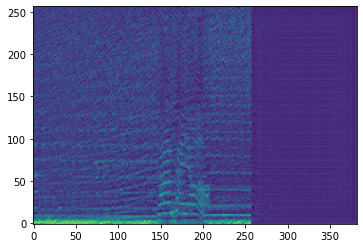

In [28]:
mag = S_left_unet[500].to('cpu').detach().numpy().reshape(257,382)
plt.imshow(mag, origin='lower')

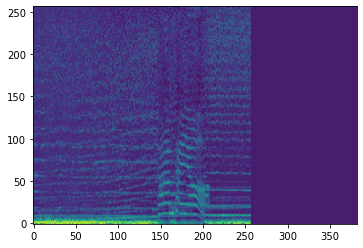

In [29]:
mag2 = scaled_L[500,:,:,:].to('cpu').detach().numpy().reshape(257,382)
plt.imshow(mag2, origin='lower')